In [326]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from pytesseract import *
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  
    

# Image is selected 

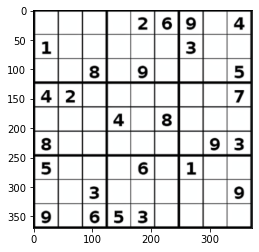

In [310]:
image = cv2.imread('test1.png')
plt.imshow(image)

# The image is processed to remove the vertical and horizontal lines.

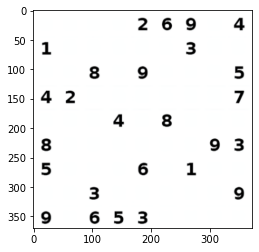

In [307]:

gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100,1))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (255,255,255), 3)

# Remove Veritical
Vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,100))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, Vertical_kernel, iterations=2)
cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (255,255,255), 3)     

# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,2))
result1 = 255 - cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)

image = result1
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


plt.imshow(result1)

# Division of the image in 81x81 blocks

In [311]:
im= result1
M = im.shape[0]//9
N = im.shape[1]//9
tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]

# Obtaining the values for each block

In [343]:
matrix = np.zeros((100,), dtype=np.int64)

txto = (pytesseract.image_to_string(result1, config='--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789'))
for celdas in range(0,95):
    img = Image.fromarray(np.uint8(tiles[celdas]))
    txt = (pytesseract.image_to_string(img, config='--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789'))
    if  txt == "" :
        matrix[celdas] = 0
    else:
        matrix[celdas] = int(txt)
        
matrix_s = np.zeros((9,9), dtype=np.int64)  #Storage of the values in the correct order 
for i in range(9):
    matrix_s[i][:] =matrix[i*10:i*10+9]

matrix_s

array([[0, 0, 0, 0, 2, 6, 9, 0, 4],
       [1, 0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 8, 0, 9, 0, 0, 0, 5],
       [4, 2, 0, 0, 0, 0, 0, 0, 7],
       [0, 0, 0, 4, 0, 8, 0, 0, 0],
       [8, 0, 0, 0, 0, 0, 0, 9, 3],
       [5, 0, 0, 0, 6, 0, 1, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 9],
       [9, 0, 6, 5, 3, 0, 0, 0, 0]], dtype=int64)

# Solving Sudoku

In [345]:
M = 9
'''0 means the cells where no value is assigned'''
grid = np.copy(matrix_s)
 
if (Suduko(grid, 0, 0)):
    puzzle(grid)
else:
    print("Solution does not exist:(")
    
def puzzle(a):
    for i in range(M):
        for j in range(M):
            print(a[i][j],end = " ")
        print()
def solve(grid, row, col, num):
    for x in range(9):
        if grid[row][x] == num:
            return False
             
    for x in range(9):
        if grid[x][col] == num:
            return False
 
 
    startRow = row - row % 3
    startCol = col - col % 3
    for i in range(3):
        for j in range(3):
            if grid[i + startRow][j + startCol] == num:
                return False
    return True
 
def Suduko(grid, row, col):
 
    if (row == M - 1 and col == M):
        return True
    if col == M:
        row += 1
        col = 0
    if grid[row][col] > 0:
        return Suduko(grid, row, col + 1)
    for num in range(1, M + 1, 1): 
     
        if solve(grid, row, col, num):
         
            grid[row][col] = num
            if Suduko(grid, row, col + 1):
                return True
        grid[row][col] = 0
    return False
 




7 3 5 1 2 6 9 8 4 
1 9 2 8 4 5 3 7 6 
6 4 8 3 9 7 2 1 5 
4 2 1 9 5 3 8 6 7 
3 6 9 4 7 8 5 2 1 
8 5 7 6 1 2 4 9 3 
5 7 4 2 6 9 1 3 8 
2 1 3 7 8 4 6 5 9 
9 8 6 5 3 1 7 4 2 


# Final response on the original image

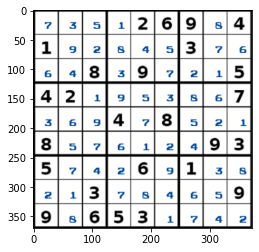

In [348]:
img = Image.open('test1.png')
 

I1 = ImageDraw.Draw(img)
font = ImageFont.truetype("AtariFontFullVersion-ZJ23.ttf",13)

# Add Text to an image
for  k in range(9):
    for  j in range(9):
        if matrix_s[k][j] !=  grid[k][j]:
            I1.text((img.size[0]*(2*j+1)/18, img.size[1]*(2*k+1)/18), str(grid[k][j]), fill=(1,75,160), font =font)
         

plt.imshow(img)
 
# Save the edited image
img.save("Sudoku_respuesta.png")